In [1]:
%%bash
DATA_DIR=/tmp/asd-diagnosis

if [ ! -d $DATA_DIR ]; then
  mkdir -p $DATA_DIR
fi

wget https://minio.131.154.99.37.myip.cloud.infn.it/hackathon-data/asd-diagnosis/functional_features.csv -O $DATA_DIR/functional_features.csv &> .log
wget https://minio.131.154.99.37.myip.cloud.infn.it/hackathon-data/asd-diagnosis/Harmonized_structural_features.csv -O $DATA_DIR/Harmonized_structural_features.csv &> .log
wget https://minio.131.154.99.37.myip.cloud.infn.it/hackathon-data/asd-diagnosis/Harmonized_functional_features.csv -O $DATA_DIR/Harmonized_functional_features.csv &> .log

ls -lrth $DATA_DIR/*

-rw-r--r-- 1 root root 417K Nov 14 10:10 /tmp/asd-diagnosis/functional_features.csv
-rw-r--r-- 1 root root 5.5M Nov 14 10:10 /tmp/asd-diagnosis/Harmonized_structural_features.csv
-rw-r--r-- 1 root root 133M Nov 14 10:12 /tmp/asd-diagnosis/Harmonized_functional_features.csv


# Autism Spectrum Disorders (ASD) diagnosis combining structural and functional Magnetic Resonance Imaging and Radiomics¶

For an introduction to Autism Spectrum Disorders (ASD) and to the dataset of this ML example please refer to the [first notebook](sMRI_fMRI_sep.ipynb). In that notebook structural and functional MRI features datasets were used separately. While here we are going to combine those datasets and evaluate if the ML model predictions have improved. 

## Usefull libraries to import

Here, you will have to read the data and pre-process them. First you need to import the necessary libraries and the apply a scaler to the data.

In [2]:
import logging, os
logging.disable(logging.WARNING)
# https://stackoverflow.com/questions/40426502/is-there-a-way-to-suppress-the-messages-tensorflow-prints/40426709
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

import warnings
# https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

## Callback

A callback is an action passed to the model fit function which is performend while training the neural network. These actions allow you to modify certain parameters when a specific condition is met while training. These actions may be implemented before or after an epoch or batch is processed, when training begins or ends and when a specific condition is met. Callbacks can help with tasks like saving the model, reducing learning rates, stopping training early, or logging performance metrics. Here we implement two actions:

* EarlyStopping
* ReduceLROnPlateau

In [3]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

early_stop = EarlyStopping(monitor='loss', patience=10)

reduce_on_plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

# Import dataframe and normalize with RobustScaler: DF_normalized

In [4]:
import pandas as pd

path_to_data = '/tmp/asd-diagnosis/'

DF_struct = pd.read_csv(os.path.join(path_to_data,'Harmonized_structural_features.csv'))
DF_funct  = pd.read_csv(os.path.join(path_to_data,'Harmonized_functional_features.csv'))

In [5]:
DF_struct = DF_struct.set_index('FILE_ID')
DF_funct = DF_funct.set_index('FILE_ID')
DF_funct= DF_funct.drop(['SITE', 'Database_Abide', 'AGE_AT_SCAN', 'DX_GROUP'], axis =1)
DF_merge = DF_struct.join(DF_funct,how='inner')
DF_merge = DF_merge.reset_index()
DF_merge.loc[DF_merge.DX_GROUP == -1, 'DX_GROUP'] = 0
DF_merge

,FILE_ID,Database_Abide,SITE,AGE_AT_SCAN,DX_GROUP,lh_caudalanteriorcingulate_GrayVol,lh_caudalanteriorcingulate_ThickAvg,lh_caudalanteriorcingulate_ThickStd,lh_caudalmiddlefrontal_GrayVol,lh_caudalmiddlefrontal_ThickAvg,...,5243,5244,5245,5246,5247,5248,5249,5250,5251,5252
0,51457,1.0,CALTECH,22.9,1,4688.148643,2.930110,0.587509,8800.363280,2.325779,...,-2.705760,-4.941687,-0.313784,-1.580897,-0.578138,0.800900,1.147299,-0.890745,4.318482,1.020236
1,51458,1.0,CALTECH,39.2,1,3984.677523,2.882359,0.460643,6547.377947,2.435749,...,-1.542383,-2.030129,0.686534,-3.049052,1.500650,-0.057321,-0.400296,0.395253,3.167437,-0.097813
2,51459,1.0,CALTECH,22.8,1,4784.864858,2.737028,0.637104,9181.350601,2.683773,...,3.010815,1.032087,-0.068159,-3.309840,-0.691436,-0.463286,-1.549897,0.358268,1.696029,-1.191784
3,51461,1.0,CALTECH,37.7,1,2139.453979,2.286036,0.518532,6268.548302,2.528375,...,2.469967,2.228592,-1.300355,1.016235,0.685534,-1.513635,0.778284,1.085581,-2.308573,-2.923374
4,51464,1.0,CALTECH,20.9,1,6194.078262,2.955411,0.831313,11308.319412,2.380809,...,1.399667,-1.951666,-1.588347,-0.684389,-1.423833,0.770992,-2.364999,3.107560,1.168626,-0.658174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,30244,2.0,U_MIA_A,9.5,0,2760.894710,2.719528,0.645727,8044.910494,2.797142,...,-2.494394,-2.287528,-2.692700,0.572010,-2.051990,-2.813308,-2.631377,-0.497931,5.814645,-1.464597
1379,30249,2.0,U_MIA_A,12.4,0,3978.719928,2.766787,0.606700,7192.725506,2.764371,...,-1.049086,-0.655575,2.143340,-4.697099,-0.670624,0.330856,-0.364826,2.593785,3.250819,1.271162
1380,30250,2.0,U_MIA_A,10.1,0,2954.162825,2.897091,0.770469,8104.601082,2.905285,...,0.638060,3.033216,-0.703276,0.765123,-0.741325,-0.049255,1.498713,-0.294101,9.475724,-0.006066
1381,30252,2.0,U_MIA_A,11.3,0,3276.342103,2.925723,0.678409,7901.169064,2.882859,...,-2.245569,1.083005,-0.479682,-0.084593,2.388419,-1.887193,2.116627,-2.294673,5.933953,0.806741


In [6]:
DF_normalized = DF_merge.drop(['SITE', 'Database_Abide', 'AGE_AT_SCAN', 'FILE_ID'], axis =1) #questa riga lasciamola che vanno tolte le feature ridondanti

In [7]:
from sklearn.preprocessing import RobustScaler

#normalize data
RS_instance = RobustScaler()
DF_normalized.iloc[:,1:] = RS_instance.fit_transform(DF_normalized.iloc[:,1:].to_numpy())
DF_normalized

,DX_GROUP,lh_caudalanteriorcingulate_GrayVol,lh_caudalanteriorcingulate_ThickAvg,lh_caudalanteriorcingulate_ThickStd,lh_caudalmiddlefrontal_GrayVol,lh_caudalmiddlefrontal_ThickAvg,lh_caudalmiddlefrontal_ThickStd,lh_cuneus_GrayVol,lh_cuneus_ThickAvg,lh_cuneus_ThickStd,...,5243,5244,5245,5246,5247,5248,5249,5250,5251,5252
0,1,1.268638,0.377530,-0.589783,0.326769,-1.746200,0.977805,-0.930078,-0.735032,0.054484,...,-0.557912,-1.667843,0.046921,-0.449884,-0.203291,0.482292,0.457513,-0.164615,-0.233920,0.474908
1,1,0.435023,0.195201,-1.497886,-0.869530,-1.260341,0.149260,-1.395270,-0.014497,-0.708084,...,-0.146633,-0.584021,0.436218,-0.952848,0.509680,0.173098,-0.099725,0.295015,-0.521565,0.056147
2,1,1.383247,-0.359718,-0.234784,0.529067,-0.164543,1.139456,-0.313275,-0.094698,0.732500,...,1.463021,0.555883,0.142512,-1.042189,-0.242149,0.026839,-0.513657,0.281796,-0.889267,-0.353597
3,1,-1.751570,-2.081748,-1.083519,-1.017585,-0.851110,0.637108,-1.274742,-0.708439,-0.928185,...,1.271820,1.001280,-0.337026,0.439847,0.230116,-0.351573,0.324643,0.541746,-1.890011,-1.002159
4,1,3.053168,0.474139,1.155356,1.658454,-1.503074,0.539329,-0.320901,-0.005986,0.303621,...,0.893446,-0.554813,-0.449105,-0.142757,-0.493343,0.471517,-0.807148,1.264425,-1.021064,-0.153735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0,-1.015162,-0.426538,-0.173057,-0.074364,0.336335,0.698862,-0.313788,-0.039112,0.038536,...,-0.483189,-0.679837,-0.878889,0.287663,-0.708784,-0.819811,-0.903062,-0.024219,0.139968,-0.455778
1379,0,0.427964,-0.246087,-0.452409,-0.526861,0.191545,-0.374590,0.293213,-0.100998,0.172274,...,0.027758,-0.072346,1.003167,-1.517439,-0.235011,0.312947,-0.086953,1.080796,-0.500728,0.568892
1380,0,-0.786139,0.251453,0.719843,-0.042670,0.814119,0.230835,0.368386,0.695370,0.510382,...,0.624201,1.300800,-0.104659,0.353820,-0.259260,0.176004,0.584045,0.048632,1.054866,0.090510
1381,0,-0.404356,0.360779,0.060875,-0.150689,0.715041,0.046943,0.291748,0.349174,-0.664107,...,-0.395224,0.574837,-0.017642,0.062723,0.814161,-0.486156,0.806535,-0.666395,0.169783,0.394945


# ASD joint structural and functional model

In [8]:
import tensorflow as tf
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

import logging
tf.get_logger().setLevel(logging.ERROR)

from tensorflow.keras.models import Model #Sequential, serve ?
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Concatenate, Dropout
from tensorflow.keras.regularizers import l1

In [9]:
def structural_model():
    """ This function returns a model ...
    """
    input_data= Input(221,)
    x = Dense(32,  'relu', kernel_initializer='normal', kernel_regularizer=l1(0.01))(input_data)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(16, 'relu',kernel_initializer='normal', kernel_regularizer=l1(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(8, 'relu',kernel_initializer='normal', kernel_regularizer=l1(0.01))(x)
    x = BatchNormalization()(x)
    #x = Dropout(0.1)(x)
    return Model(inputs=input_data, outputs=x)


def functional_model():
    """ This function returns a model ...
    """
    input_data= Input(5253,)
    x = Dense(64, 'relu', kernel_initializer= 'normal', kernel_regularizer=l1(0.01))(input_data)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(32, 'relu',kernel_initializer='normal', kernel_regularizer=l1(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(16, 'relu',kernel_initializer='normal', kernel_regularizer=l1(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(8, 'relu',kernel_initializer='normal', kernel_regularizer=l1(0.01))(x)
    x = BatchNormalization()(x)
    #x = Dropout(0.1)(x)
    return Model(inputs=input_data, outputs=x)


def joint_model(model_1, model_2):
    """ This function combines the output of two keras models
    model_1
    model_2

    returns: a new model which combines model_1 and model_2 by adding 3 dense layers
    """
    combined = Concatenate(axis=-1)([model_1.output, model_2.output])
    z = Dense(16, 'relu',  kernel_initializer= 'normal', kernel_regularizer=l1(0.01))(combined)
    z = BatchNormalization()(z)
    z = Dropout(0.2)(z)
    z = Dense(8, 'relu',  kernel_initializer= 'normal', kernel_regularizer=l1(0.01))(z)
    z = BatchNormalization()(z)
    z = Dropout(0.1)(z)
    z = Dense(1, 'sigmoid')(z) #, kernel_regularizer=l1(0.01))(z)
    return Model(inputs=[model_1.input, model_2.input], outputs = z)

**Descrivere il training**

In [10]:
DF_normalized.head()  #il dataframe deve contenere sia le features strutturali che funzionali 

,DX_GROUP,lh_caudalanteriorcingulate_GrayVol,lh_caudalanteriorcingulate_ThickAvg,lh_caudalanteriorcingulate_ThickStd,lh_caudalmiddlefrontal_GrayVol,lh_caudalmiddlefrontal_ThickAvg,lh_caudalmiddlefrontal_ThickStd,lh_cuneus_GrayVol,lh_cuneus_ThickAvg,lh_cuneus_ThickStd,...,5243,5244,5245,5246,5247,5248,5249,5250,5251,5252
0,1,1.268638,0.377530,-0.589783,0.326769,-1.746200,0.977805,-0.930078,-0.735032,0.054484,...,-0.557912,-1.667843,0.046921,-0.449884,-0.203291,0.482292,0.457513,-0.164615,-0.233920,0.474908
1,1,0.435023,0.195201,-1.497886,-0.869530,-1.260341,0.149260,-1.395270,-0.014497,-0.708084,...,-0.146633,-0.584021,0.436218,-0.952848,0.509680,0.173098,-0.099725,0.295015,-0.521565,0.056147
2,1,1.383247,-0.359718,-0.234784,0.529067,-0.164543,1.139456,-0.313275,-0.094698,0.732500,...,1.463021,0.555883,0.142512,-1.042189,-0.242149,0.026839,-0.513657,0.281796,-0.889267,-0.353597
3,1,-1.751570,-2.081748,-1.083519,-1.017585,-0.851110,0.637108,-1.274742,-0.708439,-0.928185,...,1.271820,1.001280,-0.337026,0.439847,0.230116,-0.351573,0.324643,0.541746,-1.890011,-1.002159
4,1,3.053168,0.474139,1.155356,1.658454,-1.503074,0.539329,-0.320901,-0.005986,0.303621,...,0.893446,-0.554813,-0.449105,-0.142757,-0.493343,0.471517,-0.807148,1.264425,-1.021064,-0.153735


In [11]:
import numpy as np

AUC = []
shap_values_per_cv_s =[]
shap_values_per_cv_f =[]
var_f = []
var_s = []
np.random.seed(1) # Reproducibility
n_cv = 10 #NUMERO DI KFOLD
rs_=13 
tprs = []
aucs = []
interp_fpr = np.linspace(0, 1, 100)

In [12]:
import time

from tensorflow.keras.optimizers import SGD #stochastic gradient descent
from tensorflow.keras.backend import clear_session

# import sklearn 
from sklearn.model_selection import StratifiedKFold #train_test_split, KFold
from sklearn.metrics import roc_curve, auc

import shap # colpa sua "l'errore" qui sotto: /envs/ai4ni/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
import matplotlib.pyplot as plt

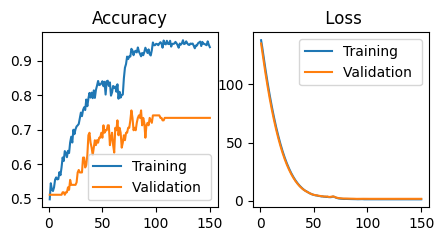

len(shap_values[0])  139
shap_values[0].shape  (139, 221, 1)
len(shap_values[1])  139
shap_values[1].shape  (139, 5253, 1)
5/5 [==============================] - 0s 3ms/step
---------------------AUC------------------ 0.7864540182270092
----------------------T------------------- 60.30060267448425



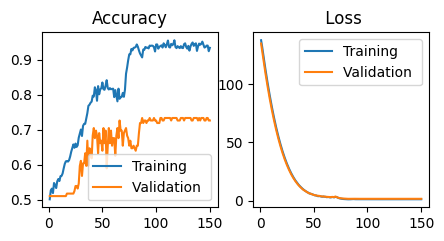

len(shap_values[0])  139
shap_values[0].shape  (139, 221, 1)
len(shap_values[1])  139
shap_values[1].shape  (139, 5253, 1)
5/5 [==============================] - 0s 3ms/step
---------------------AUC------------------ 0.7876967688483845
----------------------T------------------- 56.43438100814819



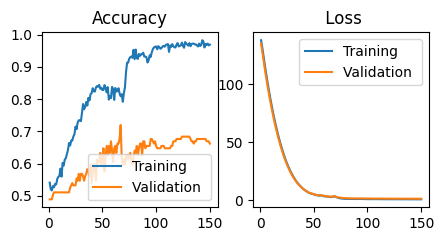

len(shap_values[0])  139
shap_values[0].shape  (139, 221, 1)
len(shap_values[1])  139
shap_values[1].shape  (139, 5253, 1)
5/5 [==============================] - 0s 3ms/step
---------------------AUC------------------ 0.7574565037282519
----------------------T------------------- 54.2494592666626



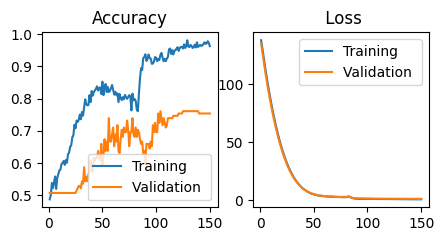

len(shap_values[0])  138
shap_values[0].shape  (138, 221, 1)
len(shap_values[1])  138
shap_values[1].shape  (138, 5253, 1)
5/5 [==============================] - 0s 3ms/step
---------------------AUC------------------ 0.8157563025210084
----------------------T------------------- 57.53407692909241



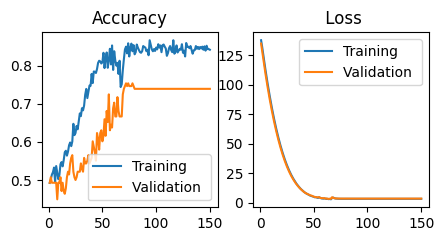

len(shap_values[0])  138
shap_values[0].shape  (138, 221, 1)
len(shap_values[1])  138
shap_values[1].shape  (138, 5253, 1)
5/5 [==============================] - 0s 3ms/step
---------------------AUC------------------ 0.7968487394957983
----------------------T------------------- 54.29940223693848



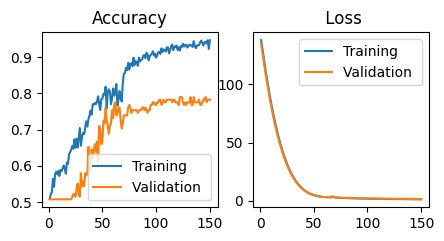

len(shap_values[0])  138
shap_values[0].shape  (138, 221, 1)
len(shap_values[1])  138
shap_values[1].shape  (138, 5253, 1)
5/5 [==============================] - 0s 4ms/step
---------------------AUC------------------ 0.8376050420168067
----------------------T------------------- 55.47121858596802



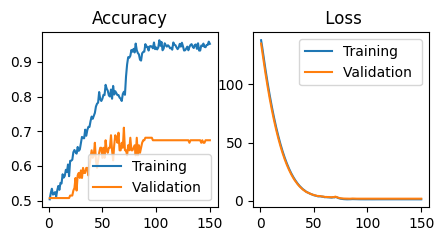

len(shap_values[0])  138
shap_values[0].shape  (138, 221, 1)
len(shap_values[1])  138
shap_values[1].shape  (138, 5253, 1)
5/5 [==============================] - 0s 3ms/step
---------------------AUC------------------ 0.7371848739495799
----------------------T------------------- 56.56703305244446



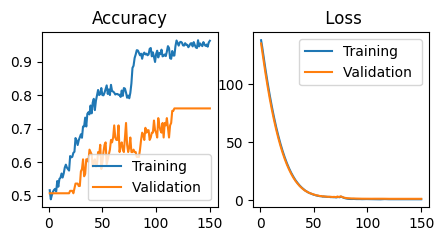

len(shap_values[0])  138
shap_values[0].shape  (138, 221, 1)
len(shap_values[1])  138
shap_values[1].shape  (138, 5253, 1)
5/5 [==============================] - 0s 3ms/step
---------------------AUC------------------ 0.8069327731092437
----------------------T------------------- 57.74908185005188



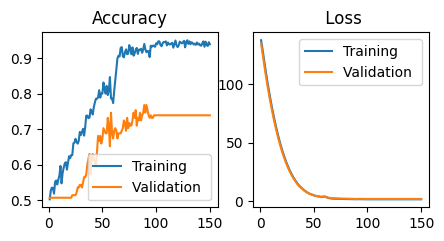

len(shap_values[0])  138
shap_values[0].shape  (138, 221, 1)
len(shap_values[1])  138
shap_values[1].shape  (138, 5253, 1)
5/5 [==============================] - 0s 3ms/step
---------------------AUC------------------ 0.8195378151260505
----------------------T------------------- 57.22382736206055



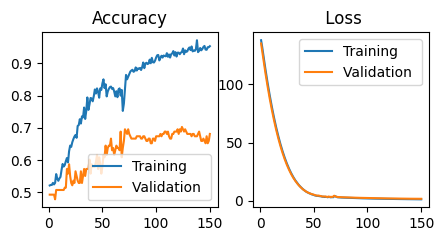

len(shap_values[0])  138
shap_values[0].shape  (138, 221, 1)
len(shap_values[1])  138
shap_values[1].shape  (138, 5253, 1)
5/5 [==============================] - 0s 3ms/step
---------------------AUC------------------ 0.7634453781512605
----------------------T------------------- 54.67034196853638



In [13]:
cv = StratifiedKFold(n_splits=n_cv, shuffle=True, random_state=rs_) # Set random state

for train_index, test_index in cv.split(DF_normalized.iloc[:, 1:], DF_normalized.iloc[:, 0]):
    start = time.time()
    df_train, df_val = DF_normalized.iloc[train_index, :], DF_normalized.iloc[test_index, :]

    X_train_struct, X_test_struct = df_train.iloc[:, 1:222], df_val.iloc[:, 1:222]
    X_train_funct, X_test_funct = df_train.iloc[:, 222:], df_val.iloc[:, 222:]
    y_train, y_test = df_train.iloc[:, 0], df_val.iloc[:, 0]

        #load the model
    clear_session()
    mod_1 = structural_model
    mod_2 = functional_model
    model_joint = joint_model(mod_1(), mod_2())

        # Compile the model
    model_joint.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

        # Fit data to model
    history = model_joint.fit((X_train_struct, X_train_funct), y_train,
                          batch_size=64,
                          epochs=150,
                          verbose=0,
                          validation_data = ((X_test_struct, X_test_funct), y_test),
                          callbacks=[reduce_on_plateau]
                          )
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(acc)+1)
    
    #Train and validation accuracy
    plt.figure(figsize=(5, 5))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training ')
    plt.plot(epochs_range, val_acc, label='Validation ')
    plt.legend(loc='lower right')
    plt.title('Accuracy')
    #Train and validation loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training ')
    plt.plot(epochs_range, val_loss, label='Validation ')
    plt.legend(loc='upper right')
    plt.title(' Loss')
    plt.show()
    
    # prepare for SHAP
    X_train_struct_SHAP = X_train_struct.to_numpy()
    X_test_struct_SHAP = X_test_struct.to_numpy()
    X_train_funct_SHAP = X_train_funct.to_numpy()
    X_test_funct_SHAP = X_test_funct.to_numpy()

    # Use SHAP to explain predictions
    explainer = shap.GradientExplainer(model_joint, [X_train_struct_SHAP, X_train_funct_SHAP])
    shap_values = explainer.shap_values([X_test_struct_SHAP, X_test_funct_SHAP])
    # nsamples maggario permettono un calcolo più accurato - rappresenta il numero di perturbazioni 200 def nsamples = 200
    #print(shap_values)
    #  SHAP information per fold
    shap_values_per_cv_s.append(shap_values[0]) #  221 features, appendo un array di dimensione 138/139,  221, 1
    shap_values_per_cv_f.append(shap_values[1]) # 5253 features, appendo un array di dimensione 138/139, 5253, 1

    print("len(shap_values[0]) ",len(shap_values[0]))
    print("shap_values[0].shape ",shap_values[0].shape)
    print("len(shap_values[1]) ",len(shap_values[1]))
    print("shap_values[1].shape ",shap_values[1].shape)

    #print(X_test_struct.shape)
        ###########################################################
    _, val_acc = model_joint.evaluate((X_test_struct, X_test_funct), y_test, verbose=0)
    acc.append(val_acc)

        #Compute Receiver operating characteristic (ROC)
    i=0
    preds = model_joint.predict((X_test_struct, X_test_funct), verbose=1)
    fpr, tpr, _ = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    interp_tpr = np.interp(interp_fpr, fpr, tpr)
    tprs.append(interp_tpr)
    AUC.append(roc_auc)
    i += 1
    print('---------------------AUC------------------', roc_auc)
    end = time.time()
    print('----------------------T-------------------', end - start)
    print("")

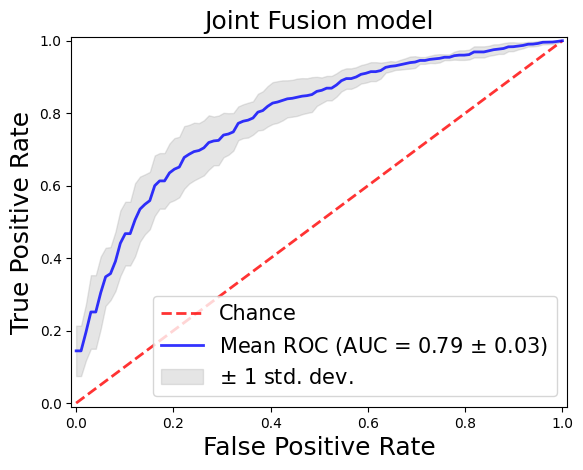

In [14]:
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
      label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(interp_fpr, mean_tpr)
std_auc = np.std(AUC)
plt.plot(interp_fpr, mean_tpr, color='b',
        label=f'Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})',
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(interp_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Joint Fusion model',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

In [15]:
# == Provide average scores ==
print(len(AUC))
print(f'AUC:{np.mean(AUC)} (+- {np.std(AUC)})')
print(f'accuracy: {np.mean(acc)} (+- {np.std(acc)})')

10
AUC:0.7908918215173394 (+- 0.029494616017794968)
accuracy: 0.8220486905401116 (+- 0.12685739010166758)


In [16]:
# Establish lists to keep average Shap values
average_shap_values_s = []
average_shap_values_f = []

for i in range(0, len(AUC)):
    df_per_obs = shap_values_per_cv_s[i].copy()
    df_per_obs = np.absolute(df_per_obs)
    average_shap_values_s.append(df_per_obs.mean(axis=0))

    df_per_f = shap_values_per_cv_f[i].copy()
    df_per_f = np.absolute(df_per_f)
    average_shap_values_f.append(df_per_f.mean(axis=0))

fold_s = np.transpose(np.array(average_shap_values_s)[...,0])
fold_f = np.transpose(np.array(average_shap_values_f)[...,0])

# SHAP values Joint model: NORMALIZATION SHAP VALUES 

In [17]:
fold_s = pd.DataFrame.from_dict(fold_s)
fold_f = pd.DataFrame.from_dict(fold_f)

In [18]:
fold_s = fold_s.iloc[:,1:]
fold_f = fold_f.iloc[:,1:]

In [19]:
s = 221/(2*(221 + 5253))
f = 5253/(2*(221 + 5253))

In [20]:
# NORMNALIZZAZIONE STRUTTURALE

fold_s_n = (fold_s/fold_s.sum(axis=0))*s*100
plot = fold_s_n.mean(axis=1).values
strutt = pd.DataFrame(plot, index = DF_normalized.iloc[:, 1:222].columns )
strutt['std']=fold_s_n.std(axis=1).values
strutt = strutt.sort_values(by=0, ascending=False)
strutt

,0,std
lh_medialorbitofrontal_ThickAvg,0.057167,0.018810
rh_pericalcarine_GrayVol,0.056416,0.015484
lh_superiortemporal_ThickAvg,0.055213,0.016923
Left-VentralDC_Volume_mm3,0.038954,0.012944
lh_entorhinal_GrayVol,0.035820,0.013020
...,...,...
lh_parstriangularis_ThickAvg,0.001659,0.000913
rh_MeanThickness,0.001153,0.001189
TotalGrayVol,0.001015,0.000672
rhCortexVol,0.000782,0.000529


In [21]:
# NORMNALIZZAZIONE FUNZIONALE

norm = fold_f.sum(axis=0)
fold_f_n = (fold_f/fold_f.sum(axis=0))*f*100
plot_f = fold_f_n.mean(axis=1).values
func = pd.DataFrame(plot_f, index = DF_normalized.iloc[:, 222:].columns )
func['std']=fold_f_n.std(axis=1).values
func = func.sort_values(by=0, ascending=False)
'''func = func.iloc[:35, :]
func.to_excel(path+'risultati_funzionali.xlsx')'''
func

,0,std
731,0.084681,0.043245
2933,0.077881,0.042535
1866,0.070891,0.026053
1632,0.069070,0.036591
2647,0.064035,0.066034
...,...,...
1170,0.001899,0.001610
4117,0.001744,0.000694
1105,0.001744,0.001818
2121,0.001558,0.000782


In [22]:
# Non capisco perche' si vada a leggere un xlsx

#func =pd.read_excel(path+'risultati_funzionali.xlsx')
#func['name'] = func['r1'].astype(str) + ' - ' + func['r2'].astype(str)

#del func['r1']
#del func['r2']
#del func['Unnamed: 0']
#func = func.set_index('name')

In [23]:
all_m_s =  pd.concat([strutt,func])
all_m_s = all_m_s.sort_values(by=0, ascending=False)
all_m_s

,0,std
731,0.084681,0.043245
2933,0.077881,0.042535
1866,0.070891,0.026053
1632,0.069070,0.036591
2647,0.064035,0.066034
...,...,...
2220,0.001444,0.000677
rh_MeanThickness,0.001153,0.001189
TotalGrayVol,0.001015,0.000672
rhCortexVol,0.000782,0.000529


In [24]:
th99 = all_m_s.iloc[:, 0].quantile(0.995)
th99

0.045394768679869225

## 99-95 esimo percentile

In [25]:
all_m_s[all_m_s[0] >= th99][0]

731                                0.084681
2933                               0.077881
1866                               0.070891
1632                               0.069070
2647                               0.064035
3004                               0.062950
3295                               0.058853
1611                               0.058395
lh_medialorbitofrontal_ThickAvg    0.057167
rh_pericalcarine_GrayVol           0.056416
4543                               0.055280
lh_superiortemporal_ThickAvg       0.055213
3254                               0.052480
3413                               0.051487
663                                0.051074
1737                               0.050156
4935                               0.048665
1855                               0.048473
2930                               0.048468
2685                               0.047756
1455                               0.046616
395                                0.046422
2854                            

Text(0.5, 0, 'mean(|SHAP value|)')

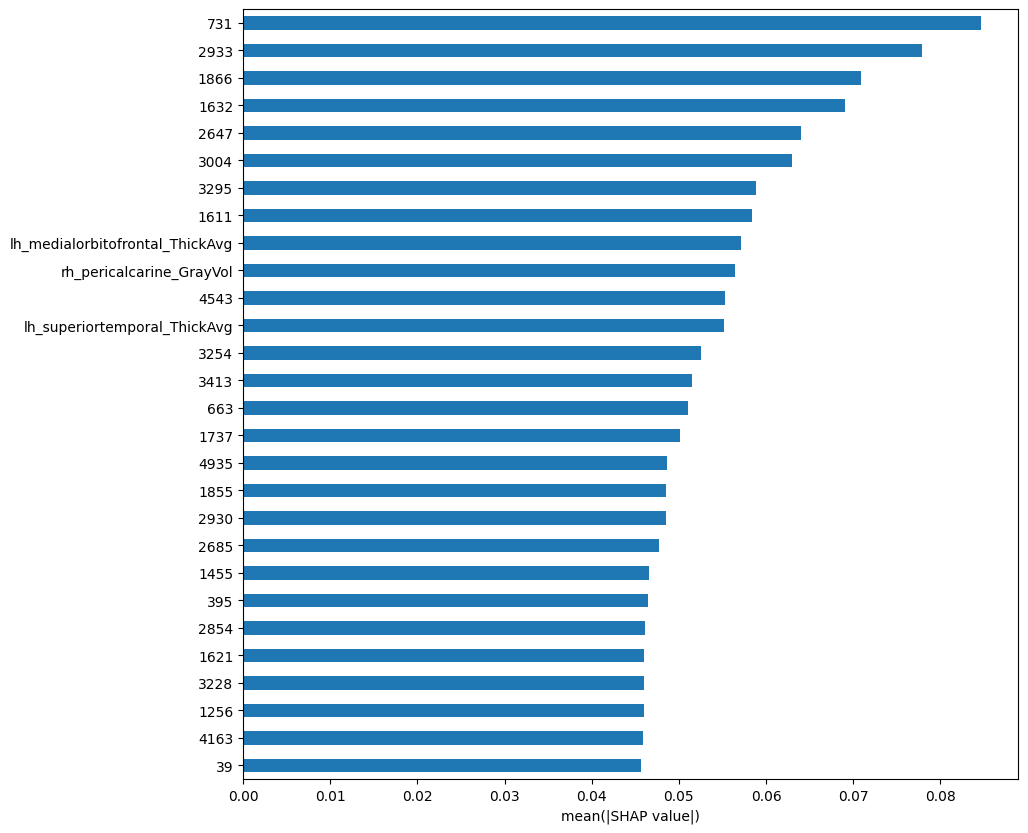

In [26]:
ax2 = plt.figure(figsize=(40, 50))
ax2 = all_m_s[all_m_s[0] >= th99][0].plot(kind="barh", figsize=(10,10))
ax2.invert_yaxis()
plt.xlabel("mean(|SHAP value|)")

## Cohen d coeff

The Cohen's *d* coefficient is a statistical measure used to quantify the *effect size* between two groups, indicating the standardized difference between their means. It is commonly used in psychology, social sciences, and other fields to assess the difference between two sample groups.

### Formula

The formula for Cohen’s *d* is:
$$
d = \frac{\bar{X}_1 - \bar{X}_2}{s}
$$
where: $\bar{X}_1$ and $\bar{X}_2$ are the means of the two groups. $s$ is the pooled standard deviation of the two groups, calculated as:
$$
s = \sqrt{\frac{(n_1 - 1)s_1^2 + (n_2 - 1)s_2^2}{n_1 + n_2 - 2}}
$$
where: $n_1$ and $n_2$ are the sample sizes of the two groups. $s_1$ and $s_2$ are the standard deviations of the two groups.

### Interpretation
Cohen's *d* provides a way to interpret the magnitude of the difference, regardless of the scale of the data, making it easier to compare across studies. Common interpretations are:
- **0.2** - Small effect size
- **0.5** - Medium effect size
- **0.8** or higher - Large effect size

These are general guidelines, and the interpretation can vary by field. Cohen's *d* is particularly helpful because it puts the difference in a standardized context, allowing researchers to understand the size of an effect without being influenced by sample size alone.

In [27]:
def Cohen_d(g1, g2, f):
    """Function to compute the Cohen's d Coefficient.

    g1: infered results by predictor 1
    g2: infered results by predictor 2
    f:  predicted class ?

    it returns the 'd' value of agreement
    """
    n1 = len(g1)                   # number of data in g1
    n2 = len(g2)                   # number of data in g2
    N = n1 + n2                    # total number of data
    Scores1 = g1[f].dropna()       # remove nan results
    Scores2 = g2[f].dropna()
    var1 = Scores1.var()           # compute the variance over the dataset
    var2 = Scores2.var()
    mean1 = Scores1.mean()         # compute the mean result
    mean2 = Scores2.mean()
    sp = (((n1 - 1)*var1 + (n2 - 1)*var2) / (N - 2))**0.5  # A me sembra tanto un confronto tra gaussiane
    d = (mean1 - mean2) / sp
    return d

In [28]:
controls = DF_normalized[DF_normalized.DX_GROUP==0]
ASD =  DF_normalized[DF_normalized.DX_GROUP==1]
list_f = all_m_s.iloc[:].index.tolist()
score_df = []
for item in list_f:
    score =  Cohen_d(ASD, controls, item)
    score_df.append(score)
    #print(item, score)
all_m_s['cohen']=score_df

In [29]:
all_m_s

,0,std,cohen
731,0.084681,0.043245,0.430465
2933,0.077881,0.042535,-0.102888
1866,0.070891,0.026053,-0.223322
1632,0.069070,0.036591,-0.331801
2647,0.064035,0.066034,-0.112380
...,...,...,...
2220,0.001444,0.000677,-0.178436
rh_MeanThickness,0.001153,0.001189,0.049612
TotalGrayVol,0.001015,0.000672,0.029290
rhCortexVol,0.000782,0.000529,0.033545


## Find region's coord in HO

In [30]:
from nilearn import datasets, plotting

dict_f = pd.read_csv('data/dict.csv')
df2 = pd.read_csv('data/functional_features.csv')
df2 = df2.set_index('F')

perc_95 = dict_f['Unnamed: 0'][0:25]
perc_95
lista_con = df2.loc[perc_95]
lista_con
all_m_s.iloc[:28, :]
'''#features ASD>TD
lista_conn = lista_con.drop(731)
lista_conn = lista_conn.drop(3254)
lista_conn = lista_conn.drop(3295)

lista_conn = lista_conn.drop(3004)
lista_conn = lista_conn.drop(1737)
lista_conn = lista_conn.drop(4545)
lista_conn = lista_conn.drop(4935)
lista_conn = lista_conn.drop(1455)
lista_conn = lista_conn.drop(395)'''


#features ASD>TD
lista_conn = lista_con.loc[[731, 3254, 3295, 3004, 1737, 4545, 4935, 1455, 395]]
lista_conn
l1 = lista_conn['r1'].to_list()
l2 = lista_conn['r2'].to_list()
l = l1 + l2
sam_list = list(set(l))
sam_list
len(sam_list)
region_c = []
label_c = []
#load HO atlas
atlas_ho = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-2mm')  #sub-maxprob-thr50-2mm - cortl-maxprob-thr25-2mm
atlas_file = atlas_ho.maps

# Load labels for each atlas region
labels = atlas_ho.labels[1:]
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_file)
print(len(labels))

atlas_ho = datasets.fetch_atlas_harvard_oxford('cortl-maxprob-thr25-2mm')
atlas_file = atlas_ho.maps
# Load labels for each atlas region
labels = atlas_ho.labels[1:]
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_file)
print(len(labels))

for i, e in enumerate(labels):
  for j, n in enumerate(sam_list):
    if e == n:
      region_c.append(coordinates[i])
      label_c.append(e)

len(label_c)

21
96


14

## PLOT connectoma

i, region_c[i],label_c[i]
0 [-24.95890023  52.9957483    7.53259637] Left Frontal Pole
i, region_c[i],label_c[i]
1 [52.31048387 28.          7.76209677] Right Inferior Frontal Gyrus, pars triangularis
i, region_c[i],label_c[i]
2 [-56.18972332  -3.65217391  -8.32411067] Left Superior Temporal Gyrus, anterior division
i, region_c[i],label_c[i]
3 [ 57.90547264  -1.30845771 -24.70149254] Right Middle Temporal Gyrus, anterior division
i, region_c[i],label_c[i]
4 [ 58.40660295 -49.15899218   1.53779322] Right Middle Temporal Gyrus, temporooccipital part
i, region_c[i],label_c[i]
5 [ 29.29266621 -47.77107608  59.07607951] Right Superior Parietal Lobule
i, region_c[i],label_c[i]
6 [-45.18003914 -75.61643836  -2.00097847] Left Lateral Occipital Cortex, inferior division
i, region_c[i],label_c[i]
7 [ -5.27058824  20.69019608 -15.08235294] Left Subcallosal Cortex
i, region_c[i],label_c[i]
8 [  6.63194444 -35.89756944  30.17708333] Right Cingulate Gyrus, posterior division
i, region_c[i],label_c[i

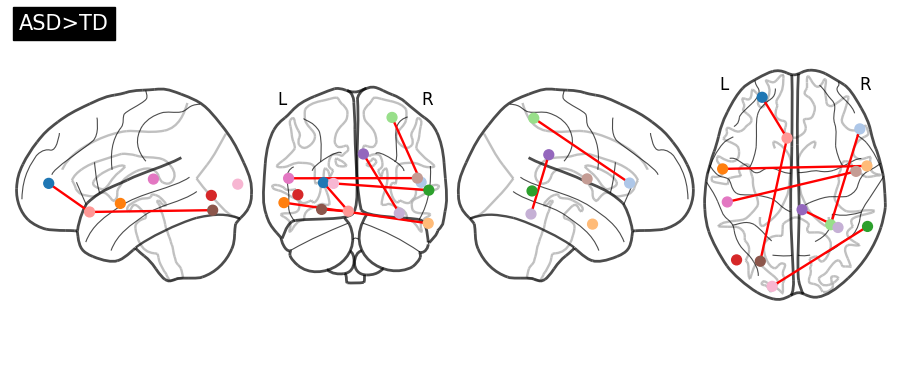

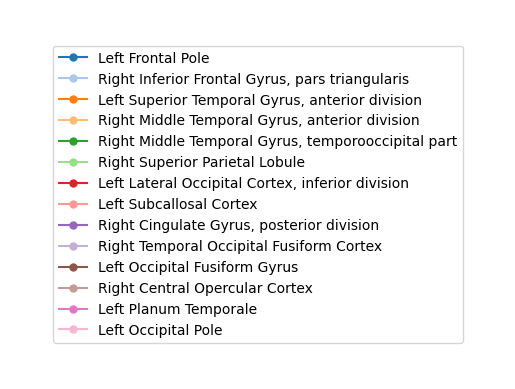

In [31]:
from matplotlib import colormaps as cm

#print("lista_conn")
#print(lista_conn)
#print("")

for i in range(0, len(label_c)):
    print("i, region_c[i],label_c[i]")
    print(i, region_c[i],label_c[i])

index_1 = []
for j, n in enumerate(l1):
    for i, e in enumerate(label_c):
        if n == e:
            index_1.append(i)

index_2=[]
for j, n in enumerate(l2):
    for i, e in enumerate(label_c):
        if n == e:
            index_2.append(i)

print("")
print("lista_conn['i1']",lista_conn['r1'])
print("lista_conn['i2']",lista_conn['r2'])

#lista_conn['r1'] = index_1
#lista_conn['r2'] = index_2
#lista_conn

mat =np.zeros((len(region_c), len(region_c)))

for index, (value1, value2) in enumerate(zip(index_1, index_2)):
    #print(index, value1 , value2)
    mat[value1][value2] = 1
mat

mat = mat + mat.T
coordinates = np.array(region_c)  # 3D coordinates of parcels

color_dict = {}
cmap = cm.get_cmap('tab20')

for rsn, c in zip(label_c, cmap.colors):
    color_dict[rsn] = tuple(c)



node_color = []
for nw in label_c:
    node_color.append(color_dict[nw])

coords = coordinates

N = len(coords)

plotting.plot_connectome(mat,
                         coords,
                         title='ASD>TD',
                         node_color=node_color,
                          display_mode="lyrz",
                         edge_kwargs = {"linewidth":1.7, "color": 'red'})

from matplotlib.lines import Line2D

legend_elements = []
for k,v in color_dict.items():
    legend_elements.append(Line2D([0], [0], marker='o', color=v, label=k,
                          markerfacecolor=v, markersize=5))
# Create the figure
fig, ax = plt.subplots()
ax.axis("off")
ax.legend(handles=legend_elements, loc='center')